In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt

In [2]:
# Jika URL tidak berfungsi, kunjungi https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# Klik kanan pada tautan 'Download Manually' untuk mendapatkan URL baru ke dataset

# Catatan: Ini adalah dataset yang sangat besar dan akan memakan waktu untuk diunduh

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2023-12-25 10:26:16--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.60.85.2, 2600:1408:c400:168a::317f, 2600:1408:c400:1680::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.60.85.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M   238MB/s    in 3.4s    

2023-12-25 10:26:20 (230 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



Now the images are stored within the `/tmp/PetImages` directory. There is a subdirectory for each class, so one for dogs and one for cats.

In [3]:
# Path sumber dataset
source_path = '/tmp/PetImages'

# Path untuk gambar anjing dan kucing
source_path_dogs = os.path.join(source_path, 'Dog')
source_path_cats = os.path.join(source_path, 'Cat')

# Menghapus semua file non-gambar (ada dua file .db dalam dataset)
!find /tmp/PetImages/ -type f ! -name "*.jpg" -exec rm {} +

# os.listdir mengembalikan daftar yang berisi semua file di bawah jalur yang diberikan
print(f"Terdapat {len(os.listdir(source_path_dogs))} gambar anjing.")
print(f"Terdapat {len(os.listdir(source_path_cats))} gambar kucing.")

Terdapat 12500 gambar anjing.
Terdapat 12500 gambar kucing.


In [4]:
# Tentukan direktori root
root_dir = '/tmp/cats-v-dogs'

# Kosongkan direktori untuk mencegah FileExistsError jika fungsi dijalankan beberapa kali
if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

# FUNGSI PENILAI: create_train_val_dirs
def create_train_val_dirs(root_path):
  # Buat direktori dengan subdirektori perantara
  os.makedirs(os.path.join(root_path, 'training'))
  os.makedirs(os.path.join(f'{root_path}/training', 'dogs'))
  os.makedirs(os.path.join(f'{root_path}/training', 'cats'))
  os.makedirs(os.path.join(root_path, 'validation'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'dogs'))
  os.makedirs(os.path.join(f'{root_path}/validation', 'cats'))


try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("Anda seharusnya tidak melihat ini karena direktori atas telah dihapus sebelumnya")

In [5]:
# Uji fungsi create_train_val_dirs

for rootdir, dirs, files in os.walk(root_dir):
    for subdir in dirs:
        print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/training/dogs
/tmp/cats-v-dogs/training/cats


In [6]:
# FUNGSI BERTINGKAT: split_data
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  # Mengacak daftar
  shuffled_source = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))

  # Menemukan total jumlah file di direktori pelatihan
  training_number = int(len(shuffled_source) * SPLIT_SIZE)

  i = 0
  target = TRAINING_DIR

  for item in shuffled_source:
    item_source = os.path.join(SOURCE_DIR, item)
    if os.path.getsize(item_source) == 0:
      print(f'{item} is zero length, so ignoring.')
    else:
      copyfile(item_source, os.path.join(target, item))
      i += 1

    # Beralih target copy ke VALIDASI
    if i == training_number:
      target = VALIDATION_DIR

In [7]:
# Tes fungsi split_data

# Tentukan path direktori
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"

TRAINING_DIR = "/tmp/cats-v-dogs/training/"
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"

TRAINING_CATS_DIR = os.path.join(TRAINING_DIR, "cats/")
VALIDATION_CATS_DIR = os.path.join(VALIDATION_DIR, "cats/")

TRAINING_DOGS_DIR = os.path.join(TRAINING_DIR, "dogs/")
VALIDATION_DOGS_DIR = os.path.join(VALIDATION_DIR, "dogs/")

# Kosongkan direktori jika sel telah dijalankan beberapa kali
if len(os.listdir(TRAINING_CATS_DIR)) > 0:
  for file in os.scandir(TRAINING_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(TRAINING_DOGS_DIR)) > 0:
  for file in os.scandir(TRAINING_DOGS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_CATS_DIR)) > 0:
  for file in os.scandir(VALIDATION_CATS_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_DOGS_DIR)) > 0:
  for file in os.scandir(VALIDATION_DOGS_DIR):
    os.remove(file.path)

# Tentukan proporsi gambar yang akan digunakan untuk pelatihan
split_size = .9

# Jalankan fungsi
# CAT_SOURCE_DIR akan memuat gambar kucing, DOG_SOURCE_DIR akan memuat gambar anjing
# Catatan: Pesan tentang gambar dengan panjang nol akan ditampilkan
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

# Periksa jumlah gambar dan bagiannya sesuai dengan yang diharapkan

# Direktori kucing dan anjing asli harus tetap tidak berubah karena fungsi ini melakukan salinan
print(f"\n\nDirektori kucing asli memiliki {len(os.listdir(CAT_SOURCE_DIR))} gambar")
print(f"Direktori anjing asli memiliki {len(os.listdir(DOG_SOURCE_DIR))} gambar\n")

# Jumlah gambar untuk pelatihan dan validasi
print(f"Ada {len(os.listdir(TRAINING_CATS_DIR))} gambar kucing untuk pelatihan")
print(f"Ada {len(os.listdir(TRAINING_DOGS_DIR))} gambar anjing untuk pelatihan")
print(f"Ada {len(os.listdir(VALIDATION_CATS_DIR))} gambar kucing untuk validasi")
print(f"Ada {len(os.listdir(VALIDATION_DOGS_DIR))} gambar anjing untuk validasi")

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


Direktori kucing asli memiliki 12500 gambar
Direktori anjing asli memiliki 12500 gambar

Ada 11250 gambar kucing untuk pelatihan
Ada 11250 gambar anjing untuk pelatihan
Ada 1249 gambar kucing untuk validasi
Ada 1249 gambar anjing untuk validasi


In [8]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  # Instansiasi kelas ImageDataGenerator (jangan lupa atur argumen rescale)
  train_datagen = ImageDataGenerator(rescale = 1./255.)

  # Berikan argumen yang sesuai ke metode flow_from_directory
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=45,
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instansiasi kelas ImageDataGenerator (jangan lupa atur argumen rescale)
  validation_datagen = ImageDataGenerator(rescale = 1./255.)

  # Berikan argumen yang sesuai ke metode flow_from_directory
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=5,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  return train_generator, validation_generator

In [9]:
# Test your generators
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 22500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


In [11]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  # DEFINISIKAN MODEL KERAS UNTUK KLASIFIKASI KUCING VS ANJING
  # GUNAKAN SETIDAKNYA 3 LAYER KONVOLUSI

  model = tf.keras.models.Sequential([
      # Perhatikan bahwa bentuk input adalah ukuran gambar yang diinginkan 150x150 dengan 3 byte warna
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten hasilnya untuk dimasukkan ke dalam DNN
      tf.keras.layers.Flatten(),
      # 512 neuron di hidden layer
      tf.keras.layers.Dense(512, activation='relu'),
      # Hanya 1 neuron output. Ini akan berisi nilai 0-1, di mana 0 untuk satu kelas ('kucing') dan 1 untuk kelas lainnya ('anjing')
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  from tensorflow.keras.optimizers import RMSprop
  model.compile(optimizer=RMSprop(learning_rate=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model


In [12]:
# Get the untrained model
model = create_model()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
498/500 [============================>.] - ETA: 0s - loss: 0.5908 - accuracy: 0.6747

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:858: UserWarning: Truncated File Read
  warnings.warn(str(msg))


500/500 [==============================] - 54s 97ms/step - loss: 0.5906 - accuracy: 0.6748 - val_loss: 0.5225 - val_accuracy: 0.7366
Epoch 2/15
500/500 [==============================] - 48s 95ms/step - loss: 0.4755 - accuracy: 0.7718 - val_loss: 0.4333 - val_accuracy: 0.8062
Epoch 3/15
500/500 [==============================] - 46s 93ms/step - loss: 0.4105 - accuracy: 0.8075 - val_loss: 0.4234 - val_accuracy: 0.8171
Epoch 4/15
500/500 [==============================] - 47s 94ms/step - loss: 0.3472 - accuracy: 0.8424 - val_loss: 0.4405 - val_accuracy: 0.8187
Epoch 5/15
500/500 [==============================] - 47s 93ms/step - loss: 0.2714 - accuracy: 0.8845 - val_loss: 0.4005 - val_accuracy: 0.8367
Epoch 6/15
500/500 [==============================] - 47s 95ms/step - loss: 0.1812 - accuracy: 0.9286 - val_loss: 0.4357 - val_accuracy: 0.8331
Epoch 7/15
500/500 [==============================] - 48s 95ms/step - loss: 0.1004 - accuracy: 0.9617 - val_loss: 0.5812 - val_accuracy: 0.8291
Epo

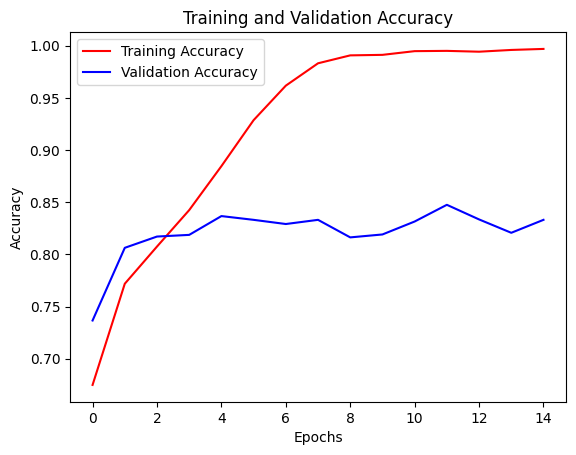

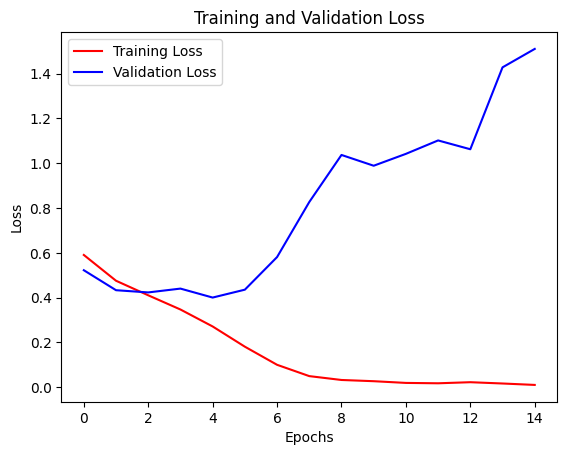

In [13]:
#-----------------------------------------------------------
# Ambil daftar hasil daftar pada data pelatihan dan pengujian
# set untuk setiap epoch pelatihan
#-----------------------------------------------------------
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))  # Dapatkan jumlah epoch

#------------------------------------------------
# Plot pelatihan dan akurasi validasi per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
print("")

#------------------------------------------------
# Plot pelatihan dan validasi loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()